In [153]:
# Code from: https://github.com/gokriznastic/HybridSN
%load_ext autoreload
%autoreload 2

import mypackage

import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Loading

In [154]:
## GLOBAL VARIABLES
test_ratio = 0.3
windowSize = 100

In [155]:
def loadData():
    data, labels, info = mypackage.Dataset.load("../../Code/data/tomra")
    labels -= 1
    return data, labels

In [156]:
X, y = loadData()

X.shape, y.shape

((34, 100, 100, 208), (34, 100, 100, 1))

In [157]:
np.unique(y)

array([0, 1, 2], dtype=int32)

In [158]:
Xtrain, Xtest, ytrain, ytest = mypackage.Dataset.train_test_split(X, y, test_ratio)
# ytrain, ytest = np.squeeze(ytrain), np.squeeze(ytest)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((23, 100, 100, 208),
 (11, 100, 100, 208),
 (23, 100, 100, 1),
 (11, 100, 100, 1))

In [159]:
K = X.shape[-1]
# Xtrain, Xtest = mypackage.Dataset.PCA(Xtrain, Xtest, n_components=K)

# Xtrain.shape

Xtrain, Xvalid, ytrain, yvalid = splitTrainTestSet(Xtrain, ytrain, 0.3333)

Xtrain.shape, Xvalid.shape, ytrain.shape, yvalid.shape

# Model and Training

In [160]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(23, 100, 100, 208, 1)

In [161]:
np.unique(ytrain)

array([0, 1, 2], dtype=int32)

In [162]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(23, 100, 100, 3)

In [163]:
S = windowSize
L = K
output_units = ytrain.shape[-1]

## TODO:
Add the upsampling

https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47

https://github.com/hlamba28/UNET-TGS/blob/master/TGS%20UNET.ipynb

###########################

https://github.com/zhixuhao/unet

https://github.com/karolzak/keras-unet

https://www.kaggle.com/krishanudb/keras-based-unet-model-construction-tutorial

### Kernel size
The first kernel depth shoud probably cover close to 100nm, which is about 28 channels. Maybe 50nm is sufficient, that is about 16 channels.

In [164]:
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add

# Code from: https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47
def conv2d_block(input_tensor, n_filters, kernel_size = 3, strides=1, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), strides=strides,\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
#     # second layer
#     x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), strides=2,\
#               kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
#     if batchnorm:
#         x = BatchNormalization()(x)
#     x = Activation('relu')(x)
    
    return x

In [165]:
batchnorm = True
n_filters = 8
dropout = 0.1

## input layer
input_layer = Input((S, S, L, 1))

## convolutional layers
conv_layer1 = Conv3D(n_filters * 1, kernel_size=(3, 3, 7), strides=(1, 1, 3), activation='relu')(input_layer)
conv_layer2 = Conv3D(n_filters * 2, kernel_size=(3, 3, 5), strides=(2, 2, 3), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(n_filters * 4, kernel_size=(3, 3, 3), strides=(2, 2, 3), activation='relu')(conv_layer2)
conv3d_shape = conv_layer3._keras_shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)

# conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

c4 = conv2d_block(conv_layer3, n_filters * 8, kernel_size = 3, strides=2, batchnorm = batchnorm)
# p4 = MaxPooling2D((2, 2))(c4)
p4 = Dropout(dropout)(c4)

c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, strides=2, batchnorm = batchnorm)
print(f"c4: {c4._keras_shape}")

# Expansive Path
u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
print(f"u6: {u6._keras_shape}")
u6 = concatenate([u6, c4])
u6 = Dropout(dropout)(u6)
c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
# u7 = concatenate([u7, conv_layer3]) # TODO: Maybe use https://keras.io/layers/pooling/ # MaxPooling3D to reduce the spectral dimension
u7 = Dropout(dropout)(u7)
c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
# u8 = concatenate([u8, conv_layer2])
u8 = Dropout(dropout)(u8)
c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
# u9 = concatenate([u9, conv_layer1])
u9 = Dropout(dropout)(u9)
c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

outputs = Conv2D(output_units, (1, 1), activation='sigmoid')(c9)
model = Model(inputs=input_layer, outputs=outputs)
model.summary()

c4: (None, 12, 12, 64)
u6: (None, 12, 12, 64)
Model: "model_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_59 (InputLayer)           (None, 100, 100, 208 0                                            
__________________________________________________________________________________________________
conv3d_175 (Conv3D)             (None, 98, 98, 68, 8 512         input_59[0][0]                   
__________________________________________________________________________________________________
conv3d_176 (Conv3D)             (None, 48, 48, 22, 1 5776        conv3d_175[0][0]                 
__________________________________________________________________________________________________
conv3d_177 (Conv3D)             (None, 23, 23, 7, 32 13856       conv3d_176[0][0]                 
_____________________________________________

In [166]:
# compiling the model
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [167]:
# checkpoint
filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [168]:
Xtrain.shape, ytrain.shape

((23, 100, 100, 208, 1), (23, 100, 100, 3))

In [169]:
ytrain[:, 2:-2, 2:-2, :].shape

(23, 96, 96, 3)

In [149]:
# import matplotlib.pyplot as plt
# plt.imshow(ytrain[0])

In [172]:
# Had batch_size=256
history = model.fit(x=Xtrain, y=ytrain[:, 2:-2, 2:-2, :], batch_size=50, epochs=10, callbacks=callbacks_list)

Epoch 1/10
23/23 [==============================] - 12s 529ms/step - loss: 0.8491 - accuracy: 0.8147

Epoch 00001: accuracy improved from 0.81297 to 0.81470, saving model to best-model.hdf5
Epoch 2/10
23/23 [==============================] - 10s 422ms/step - loss: 0.8451 - accuracy: 0.8157

Epoch 00002: accuracy improved from 0.81470 to 0.81567, saving model to best-model.hdf5
Epoch 3/10
23/23 [==============================] - 8s 326ms/step - loss: 0.8412 - accuracy: 0.8154

Epoch 00003: accuracy did not improve from 0.81567
Epoch 4/10
23/23 [==============================] - 9s 391ms/step - loss: 0.8371 - accuracy: 0.8151

Epoch 00004: accuracy did not improve from 0.81567
Epoch 5/10
23/23 [==============================] - 8s 362ms/step - loss: 0.8337 - accuracy: 0.8145

Epoch 00005: accuracy did not improve from 0.81567
Epoch 6/10
23/23 [==============================] - 8s 327ms/step - loss: 0.8299 - accuracy: 0.8135

Epoch 00006: accuracy did not improve from 0.81567
Epoch 7/10
2

In [209]:
# plt.figure(figsize=(7,7))
# plt.grid()
# plt.plot(history.history['loss'])
# #plt.plot(history.history['val_loss'])
# plt.ylabel('Loss')
# plt.xlabel('Epochs')
# plt.legend(['Training','Validation'], loc='upper right')
# plt.show()

In [210]:
# plt.figure(figsize=(5,5))
# plt.ylim(0,1.1)
# plt.grid()
# plt.plot(history.history['accuracy'])
# #plt.plot(history.history['val_acc'])
# plt.ylabel('Accuracy')
# plt.xlabel('Epochs')
# plt.legend(['Training','Validation'])
# plt.show()

# Validation

In [173]:
# load best weights
model.load_weights("best-model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [174]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(11, 100, 100, 208, 1)

In [175]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(11, 100, 100, 3)

In [199]:
y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(y_pred_test, axis=-1)

# target_names = ['Belt','Meat','Plastic']
classification = classification_report(np.argmax(ytest[:, 2:-2, 2:-2, :], axis=-1).flatten(),\
                                                 y_pred_test.flatten())
print(classification)

              precision    recall  f1-score   support

           0       1.00      0.19      0.32     84355
           1       0.58      0.67      0.62     15749
           2       0.00      0.13      0.00      1272

    accuracy                           0.26    101376
   macro avg       0.53      0.33      0.31    101376
weighted avg       0.92      0.26      0.36    101376



In [197]:
np.unique(np.argmax(y_pred_test, axis=-1))

array([0, 1, 2])

In [198]:
ytest.shape

(11, 100, 100, 3)

Text(0.5, 1.0, 'True label')

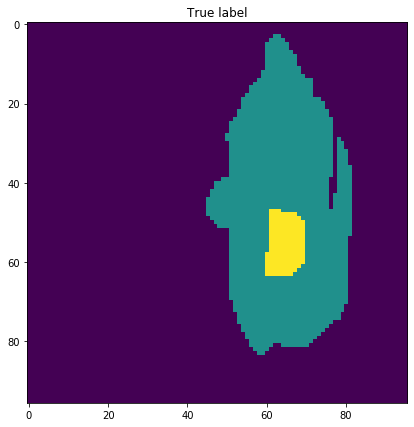

In [205]:
plt.figure(figsize=(7,7))
plt.imshow(np.argmax(ytest[:, 2:-2, 2:-2, :], axis=-1)[0])
plt.title("True label")

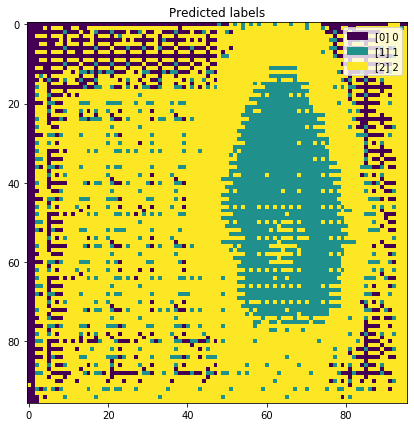

In [204]:
plt.figure(figsize=(7,7))
img = plt.imshow(y_pred_test[0])
mypackage.Dataset._Dataset__add_legend_to_image(y_pred_test[0], img)
plt.title("Predicted labels")
plt.show()

In [ ]:
ground_truth = spectral.imshow(classes = np.squeeze(y),figsize =(7,7))

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [ ]:
# spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)

spectral.save_rgb(str(dataset)+"_ground_truth.jpg", y, colors=spectral.spy_colors)